# (For colab)

In [ ]:
!pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
import condacolab
condacolab.install_mambaforge()
!wget -q https://raw.githubusercontent.com/openforcefield/symposium_2024_demo/main/colab-environment.yml
!wget -q https://raw.githubusercontent.com/openforcefield/symposium_2024_demo/main/last_frame_lig.pdb
!mamba env update -q --name=base --file=colab-environment.yml

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# OpenFF's 2024 OMSF Symposium demo

In [ ]:
from pathlib import Path

import ipywidgets as widgets
import mdtraj
import nglview
import numpy
import numpy as np
import openmm
import openmm.unit as omm_unit
import rdkit
from openff.interchange import Interchange
from openff.interchange.drivers.openmm import get_openmm_energies
from openff.toolkit import AmberToolsToolkitWrapper, ForceField, Molecule, Topology
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
from openff.units import Quantity, ensure_quantity, unit
from openff.units.openmm import from_openmm
from openmm.app import Simulation
from pdbfixer import PDBFixer

# Warm up NAGL
ntkw = NAGLToolkitWrapper()
ntkw.assign_partial_charges(Molecule.from_smiles('C'), "openff-gnn-am1bcc-0.1.0-rc.2.pt")

In [ ]:
from openff.toolkit import ForceField, Molecule, Topology

top = Topology.from_pdb(
    "complex_topology.pdb",
    unique_molecules=[Molecule.from_smiles("c12c(Cl)cccc1sc(C(=O)[O-])c(Cl)2")],
)
protein = top.molecule(0)
ligand = top.molecule(1)
top.visualize()

In [ ]:
top.to_file('temp.pdb')
fixer = PDBFixer('temp.pdb')
fixer.addSolvent(
    padding=0.5 * omm_unit.nanometer, ionicStrength=0.15 * omm_unit.molar
)

with open("receptor_solvated.pdb", "w") as f:
    openmm.app.PDBFile.writeFile(fixer.topology, fixer.positions, f)
top = Topology.from_pdb("receptor_solvated.pdb", 
                        unique_molecules=[top.molecule(1)])

In [ ]:
top.visualize()

In [ ]:
ff = ForceField("openff-2.2.0.offxml", "ff14sb_off_impropers_0.0.4.offxml")
interchange = ff.create_interchange(top)
integrator = openmm.LangevinMiddleIntegrator(
        300 * omm_unit.kelvin,
        1 / omm_unit.picosecond,
        0.002 * omm_unit.picoseconds,
    )

simulation = interchange.to_openmm_simulation(integrator)
simulation.minimizeEnergy(tolerance=100)
dcd_reporter = openmm.app.DCDReporter(file="trajectory.dcd", 
                                      reportInterval=10
                                     )
simulation.reporters.append(dcd_reporter)
simulation.step(1000)


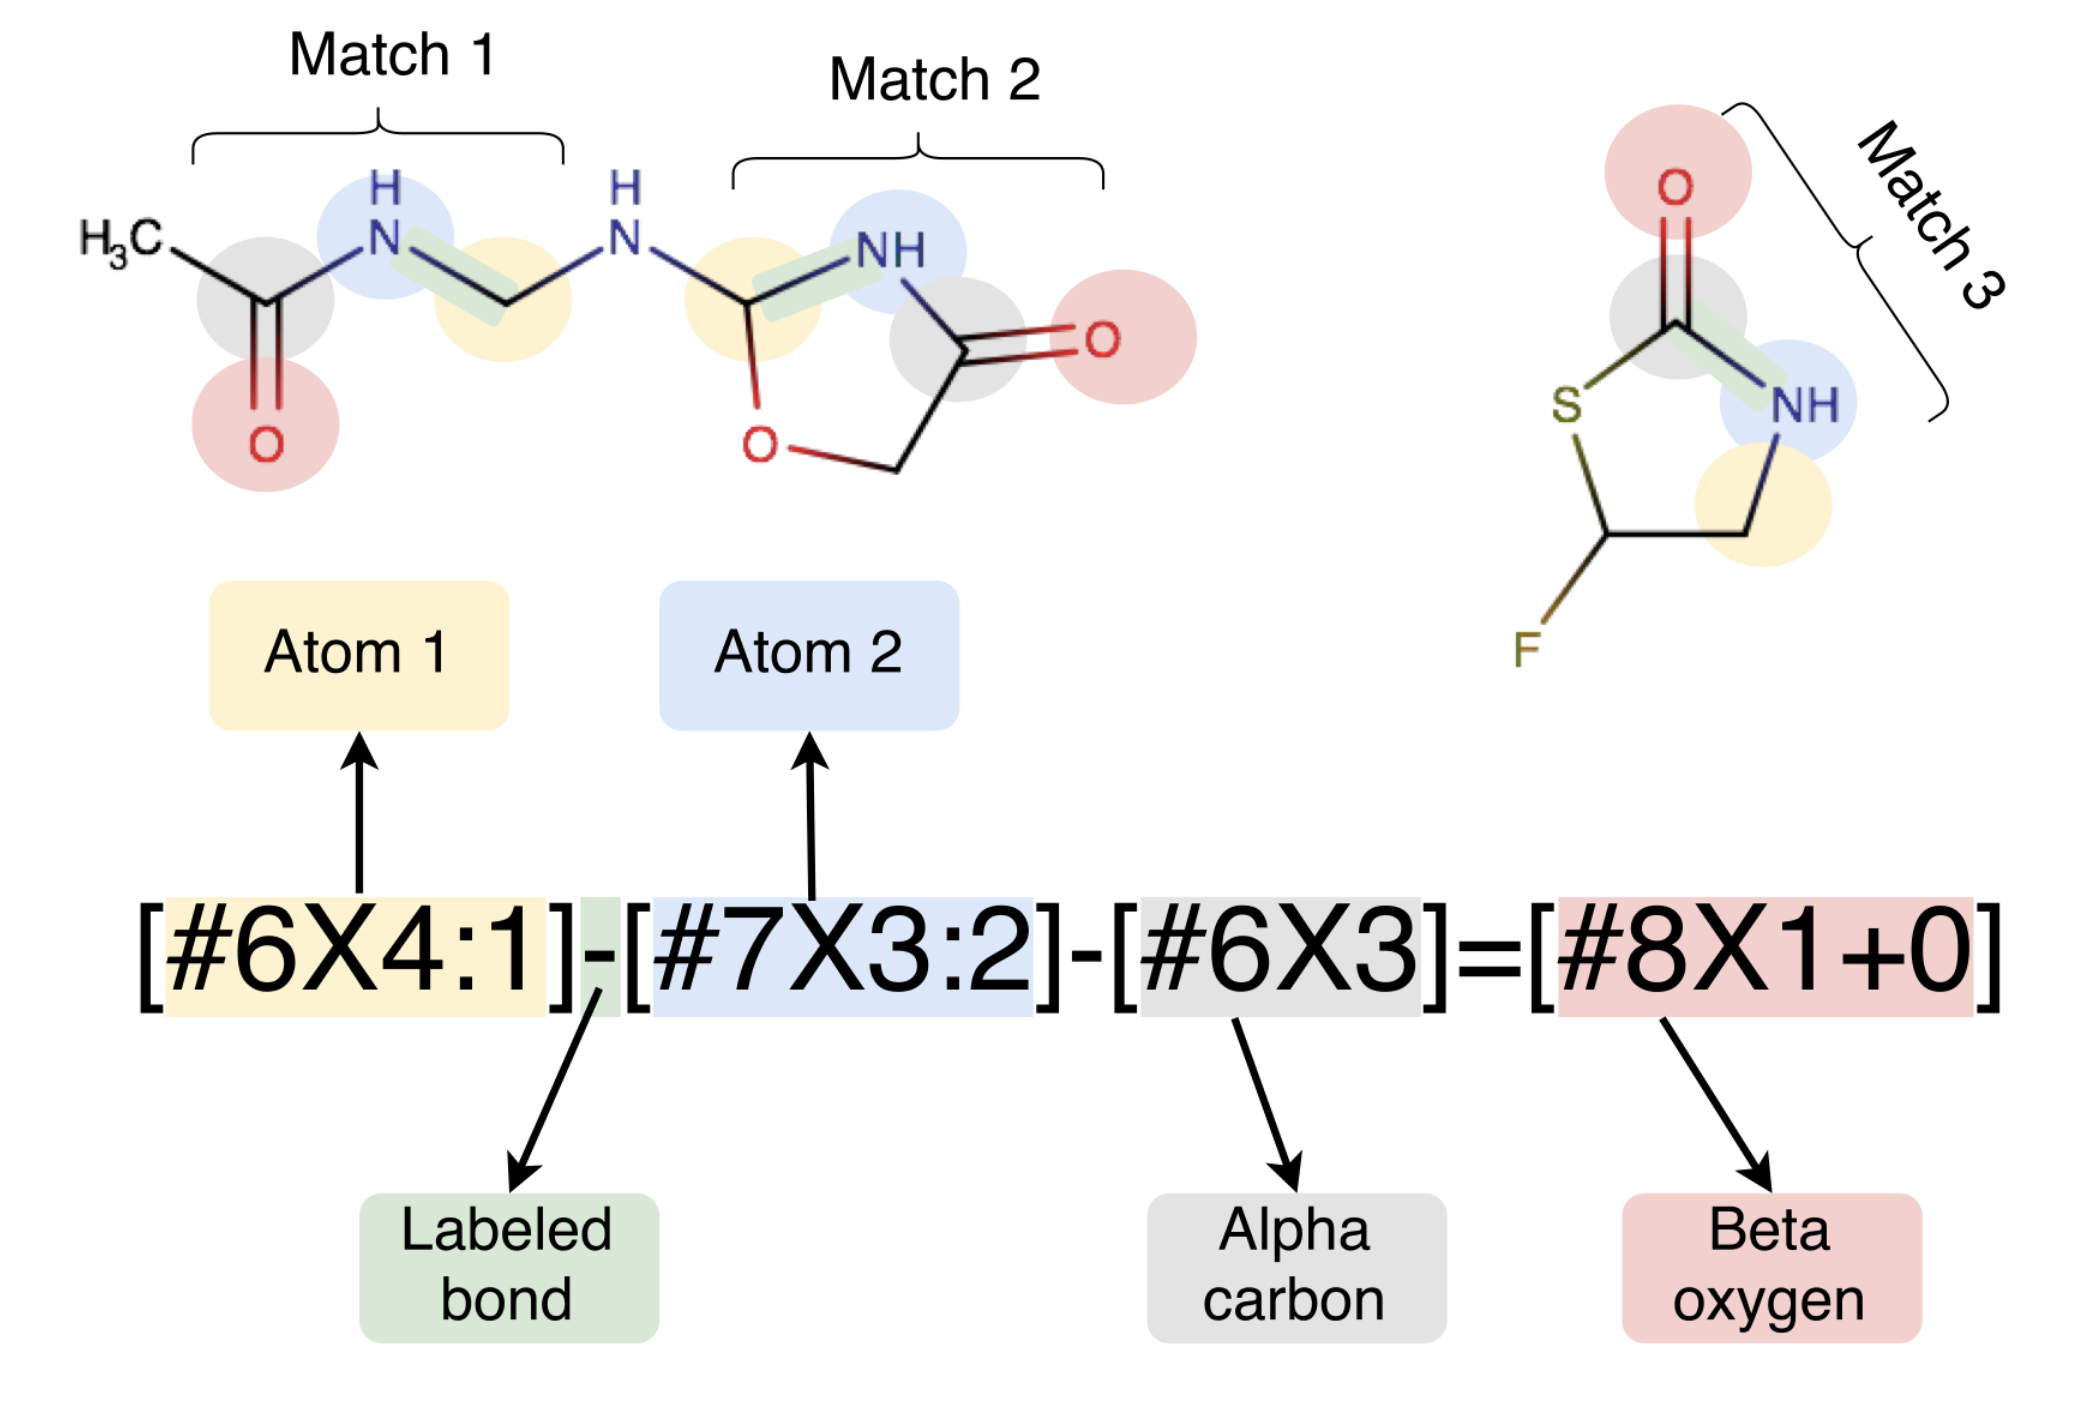
## Let's take a look at OpenFF-2.2.0

In [ ]:
trajectory: mdtraj.Trajectory = mdtraj.load(
    "trajectory.dcd", top=mdtraj.Topology.from_openmm(interchange.to_openmm_topology())
)
view = nglview.show_mdtraj(trajectory.image_molecules())
view.add_representation("line", selection="protein")
view.add_line(selection="water")
view

# Thank you!
# 
# 









# Oh, is there still time? 


# NAGL is really fast

In [ ]:
linezolid = Molecule.from_smiles("O=C1O[C@@H](CNC(=O)C)CN1c3cc(F)c(N2CCOCC2)cc3")

linezolid.visualize(show_all_hydrogens=False)

In [ ]:
#AmberToolsToolkitWrapper().assign_partial_charges(linezolid, "am1bcc")

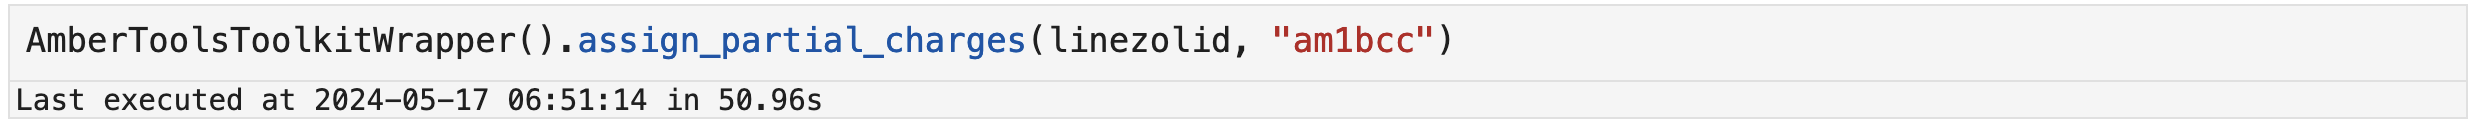

In [ ]:
#linezolid.to_file("linezolid_ambertools_charges.sdf", file_format="sdf")

In [ ]:
NAGLToolkitWrapper().assign_partial_charges(linezolid, 
                                            "openff-gnn-am1bcc-0.1.0-rc.2.pt")


In [ ]:
from matplotlib import pyplot
linezolid_at_charges = Molecule.from_file("linezolid_ambertools_charges.sdf")
linezolid_oe_charges = Molecule.from_file("linezolid_openeye_charges.sdf")
pyplot.bar(range(linezolid.n_atoms), 
           (linezolid_oe_charges.partial_charges - linezolid.partial_charges).m_as(unit.elementary_charge),
          )


In [ ]:
pyplot.bar(range(linezolid.n_atoms), 
           (linezolid_oe_charges.partial_charges - linezolid_at_charges.partial_charges).m_as(unit.elementary_charge),
          )


# Interchange is also swell



In [ ]:
protein = Topology.from_pdb("selected_prediction_aligned.pdb")
ff14sb = ForceField("ff14sb_off_impropers_0.0.4.offxml")
protein_interchange = ff14sb.create_interchange(protein)

ligand = Molecule.from_file("posed_ligand.sdf")
sage = ForceField("openff-2.2.0.offxml")
ligand_interchange = sage.create_interchange(ligand.to_topology())

In [ ]:
env INTERCHANGE_EXPERIMENTAL=1

In [ ]:
complex_interchange = protein_interchange.combine(ligand_interchange)

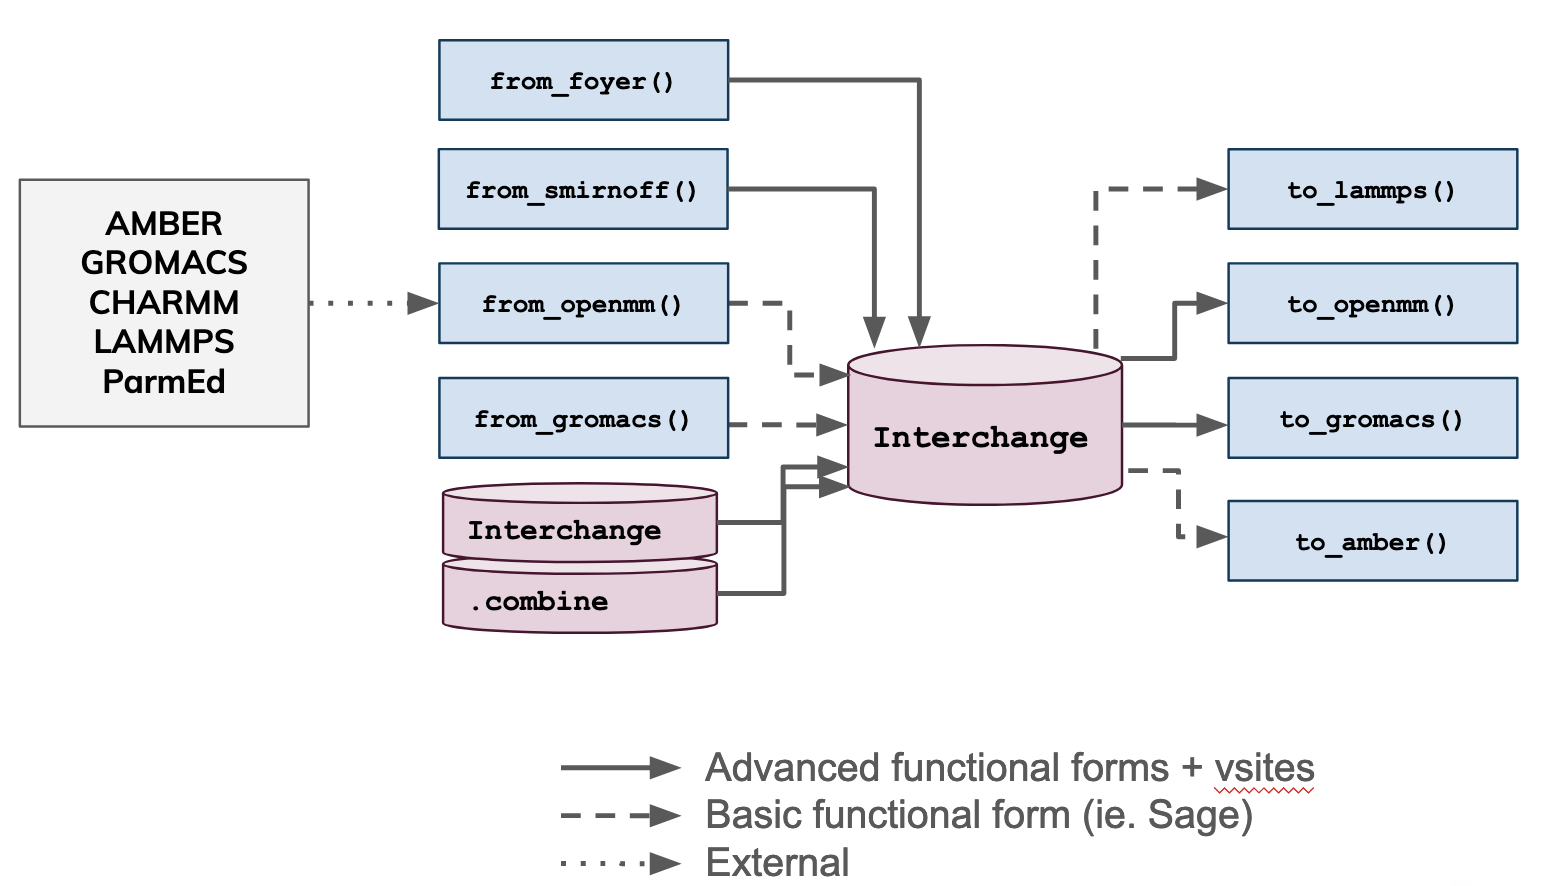

In [ ]:
complex_interchange.visualize()

# Something has been bugging me...

In [ ]:
view = nglview.show_file("selected_prediction_aligned.pdb")
view.add_representation("surface", selection="protein", opacity=0.7, opaqueBack=False)
view.add_component("4hw3_D_aligned.pdb")
view

# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
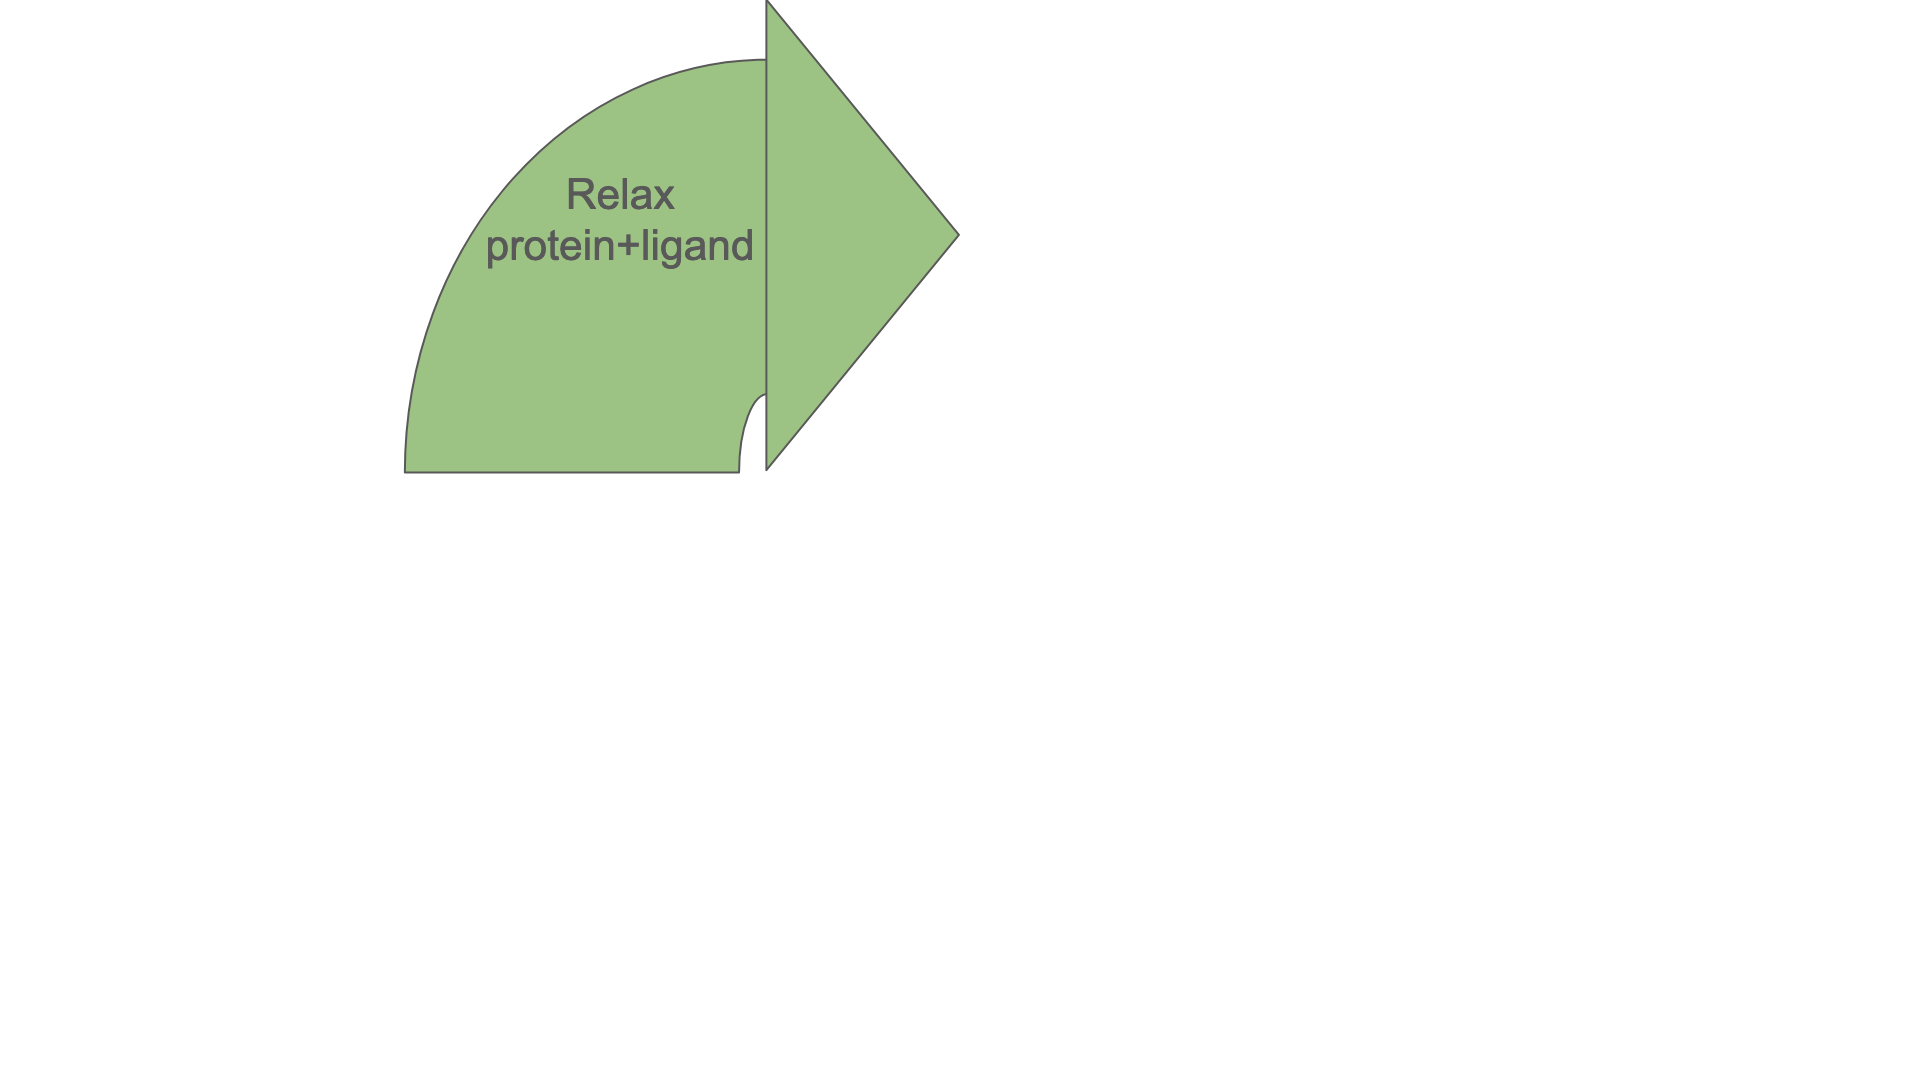

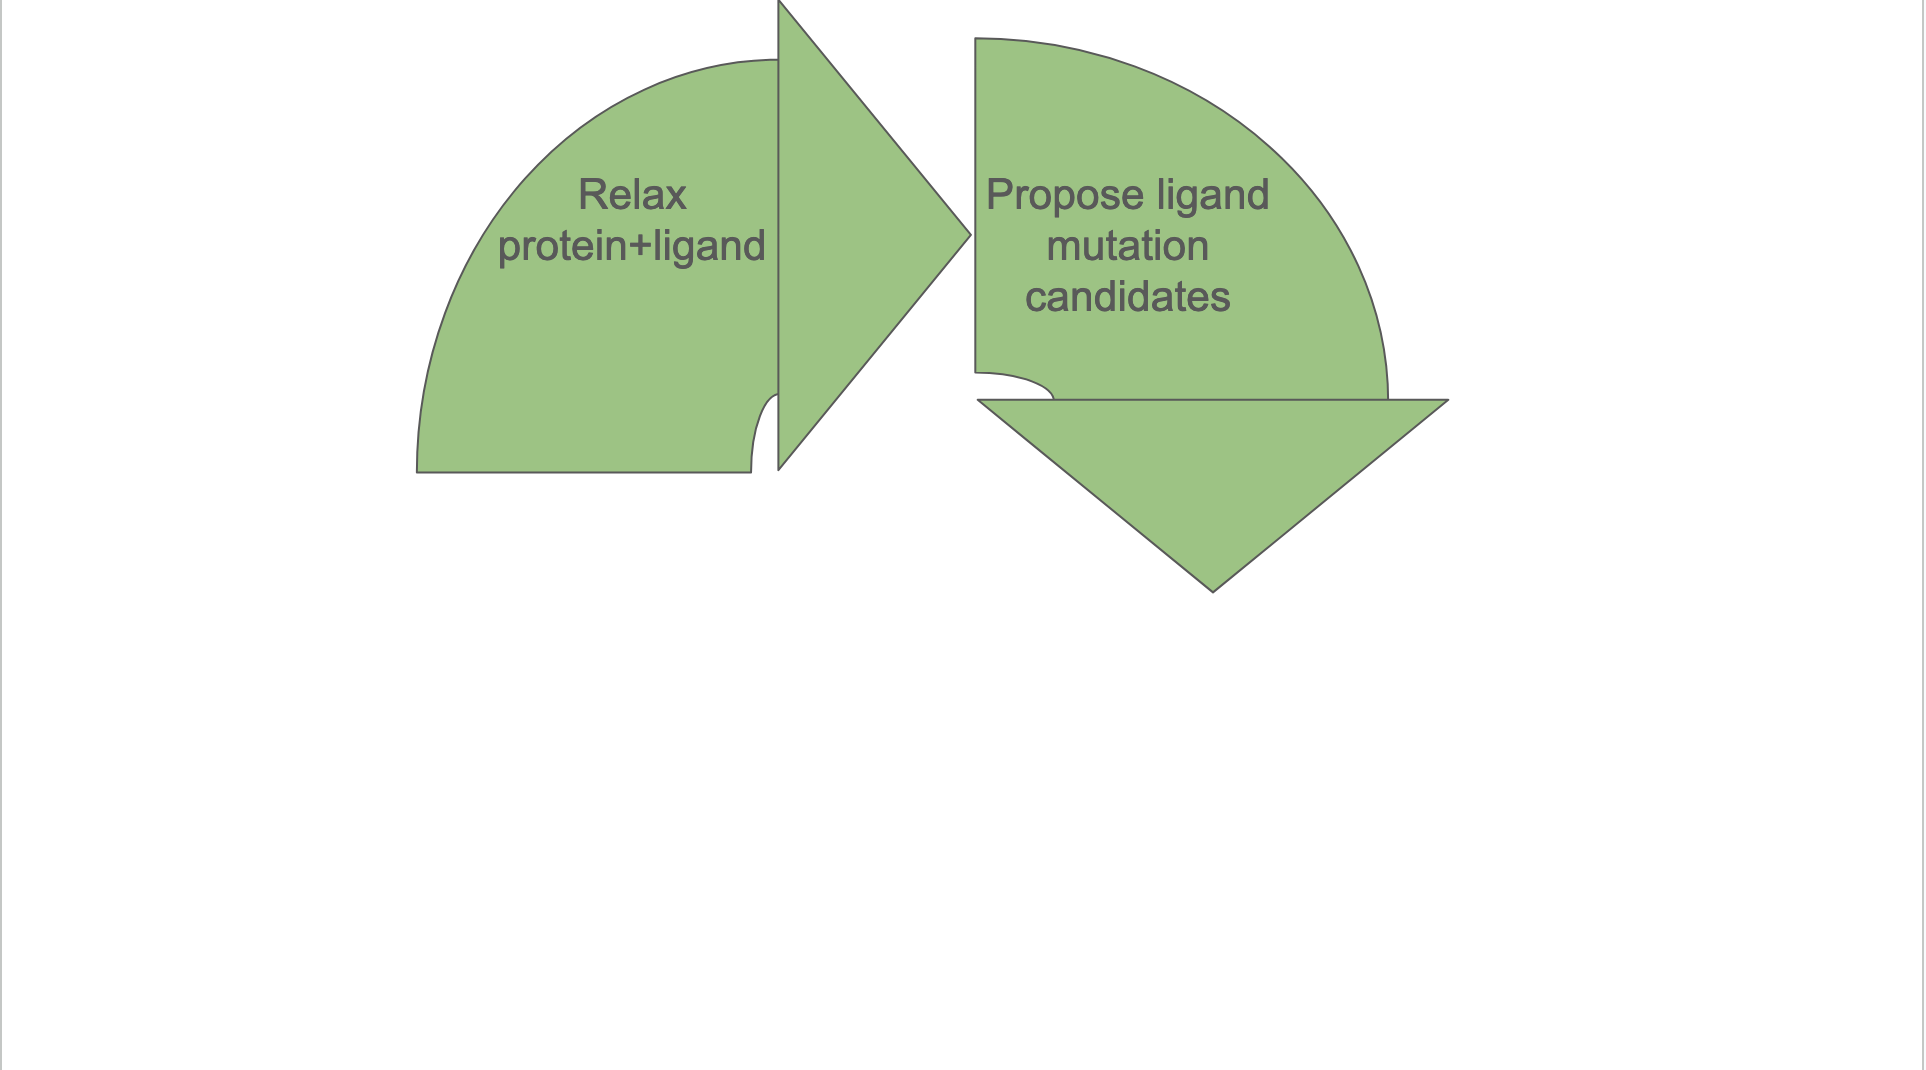

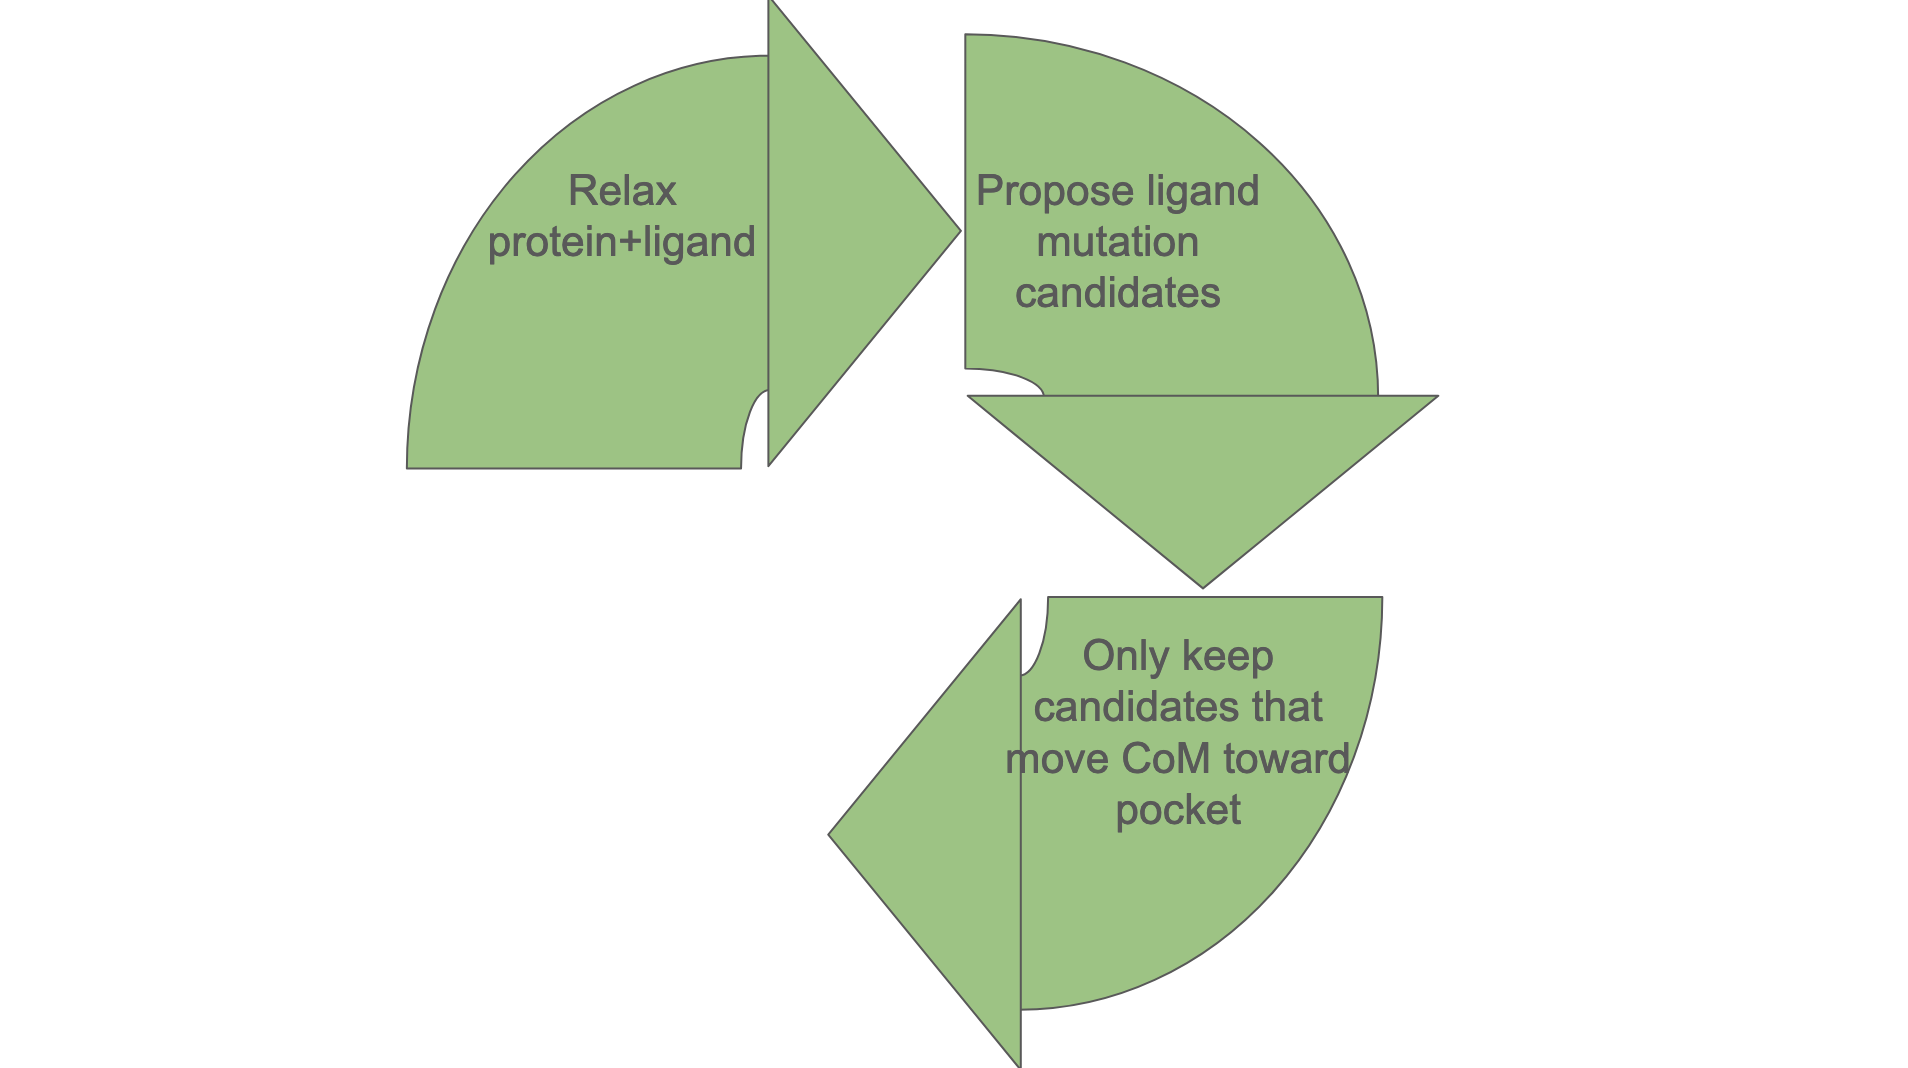

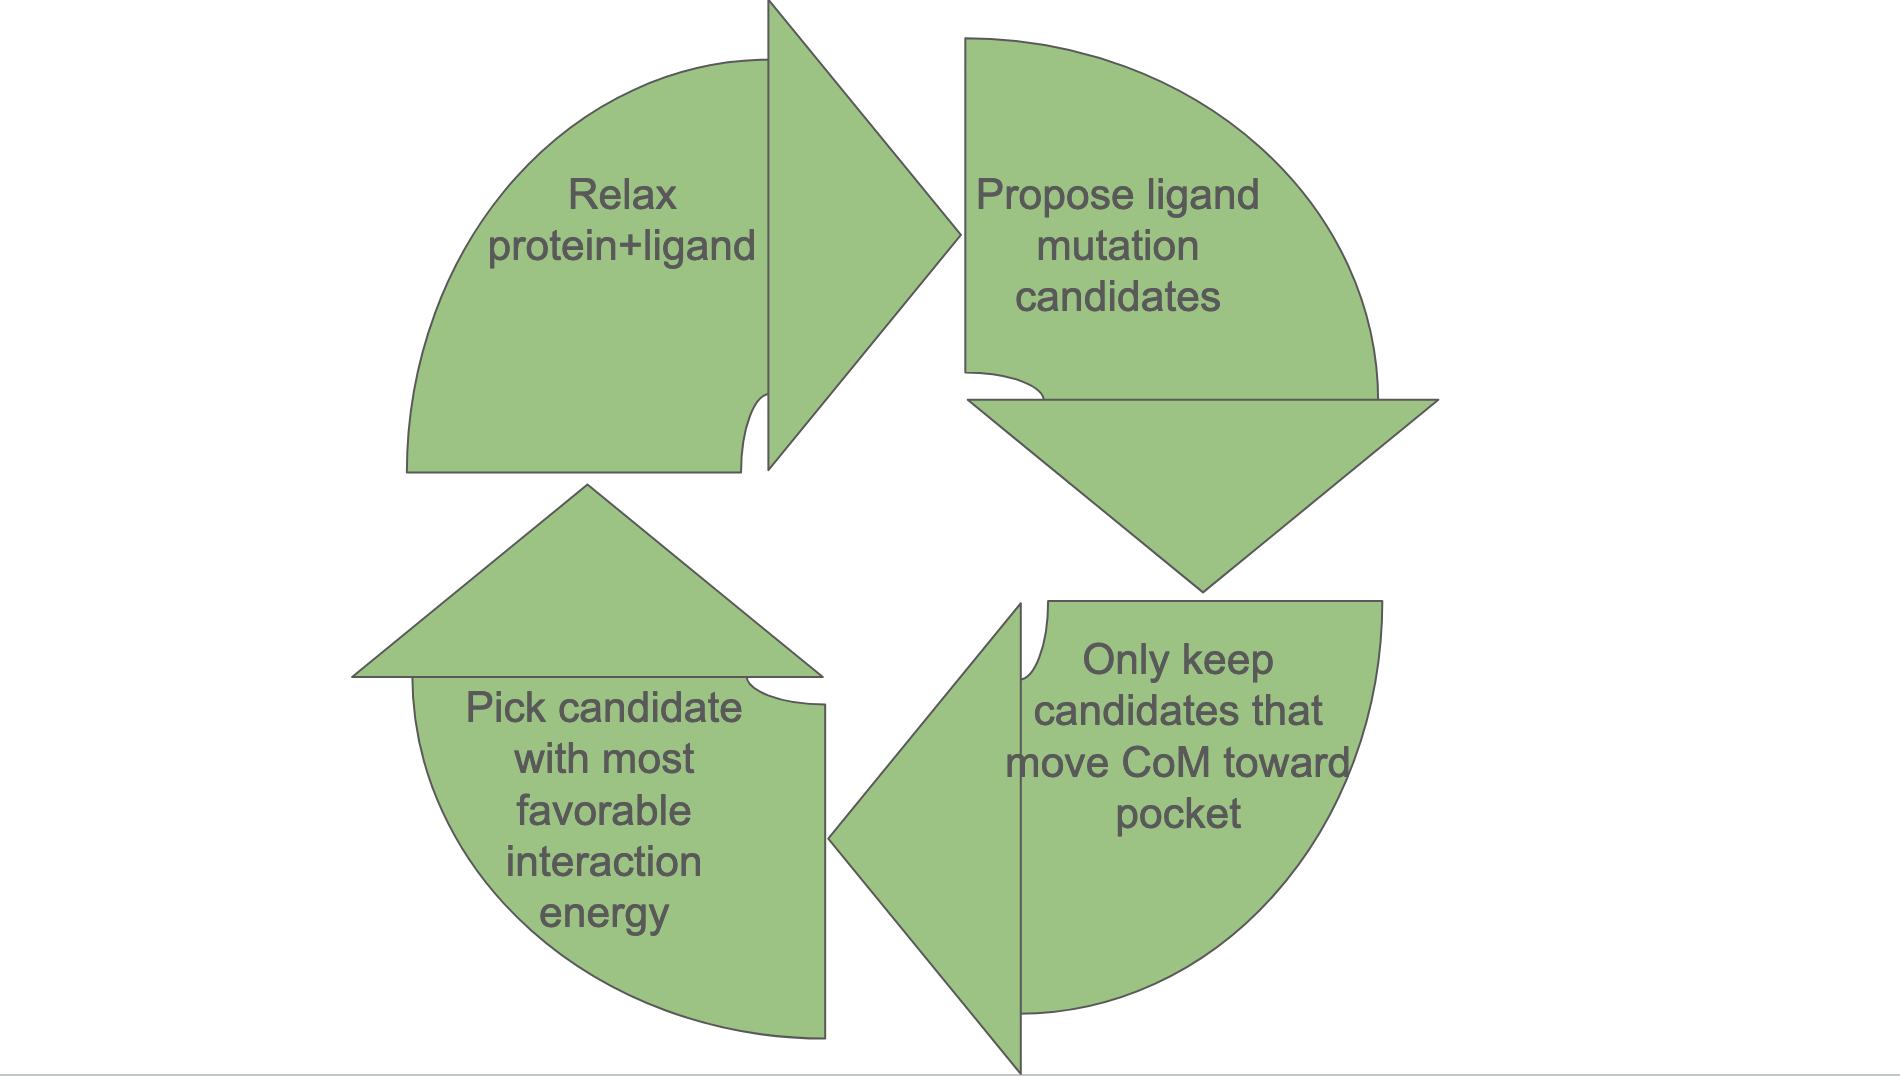



In [ ]:
top = Topology.from_pdb(
    "complex_topology.pdb",
    unique_molecules=[Molecule.from_smiles("c12c(Cl)cccc1sc(C(=O)[O-])c(Cl)2")],
)
protein = top.molecule(0)
ligand = top.molecule(1)
top.visualize()

In [ ]:


def mutate_ligand(ligand):
    ligand.partial_charges = None
    rdmol = ligand.to_rdkit()
    reactions = [
        "[*:1]-[*X1:2] >> [*:1][C:2]",
        "[#6:1]-[#1:2] >> [*:1][N:2]",
        "[#6:1]-[#1:2] >> [*:1][O:2]",
    ]
    unsanitized_products = []
    for reaction in reactions:
        rxn = rdkit.Chem.rdChemReactions.ReactionFromSmarts(reaction)
        unsanitized_products.extend(rxn.RunReactants([rdmol]))

    products = list()
    for (product,) in unsanitized_products:
        mol_copy = rdkit.Chem.Mol(product)

        rdkit.Chem.SanitizeMol(mol_copy, rdkit.Chem.SANITIZE_ALL)
        rdkit.Chem.AssignStereochemistryFrom3D(mol_copy)
        rdkit.Chem.Kekulize(mol_copy, clearAromaticFlags=True)
        rdkit.Chem.SetAromaticity(mol_copy, rdkit.Chem.AromaticityModel.AROMATICITY_MDL)
        offmol = Molecule.from_rdkit(mol_copy)
        existing_metadata = [
            atom.metadata for atom in offmol.atoms if atom.metadata != {}
        ][0]
        for atom in offmol.atoms:
            atom.metadata.update(existing_metadata)
        products.append(offmol)
    return products


def display_molecule_grid(molecules, item_width=200):

    items = []
    for product in molecules:
        item = widgets.Output()
        item.append_display_data(product.visualize("rdkit", width=item_width))
        items.append(item)

    return widgets.GridBox(
        items,
        layout=widgets.Layout(grid_template_columns=f"repeat(3, {item_width+10}px)"),
    )

In [ ]:
products = mutate_ligand(ligand)
display_molecule_grid(products)

In [ ]:

def single_point_energy(
    simulation: Simulation, positions: Quantity, box_vectors: Quantity | None
) -> Quantity:
    """Calculate a single point energy with OpenMM"""
    simulation.context.setPositions(ensure_quantity(positions, "openmm"))
    if box_vectors is not None:
        simulation.context.setPeriodicBoxVectors(
            *ensure_quantity(box_vectors, "openmm")
        )
    state = simulation.context.getState(getEnergy=True)
    return ensure_quantity(state.getPotentialEnergy(), "openff")


def create_integrator() -> openmm.Integrator:
    return openmm.LangevinMiddleIntegrator(
        300 * omm_unit.kelvin,
        1 / omm_unit.picosecond,
        0.002 * omm_unit.picoseconds,
    )


In [ ]:


def relax_ligand(protein_interchange, ligand_offmol, ligand_ff, name=""):
    # Use NAGL to quickly charge the ligand
    ntkw = NAGLToolkitWrapper()
    ntkw.assign_partial_charges(ligand_offmol, "openff-gnn-am1bcc-0.1.0-rc.2.pt")
    ligand_interchange = sage.create_interchange(
        ligand_offmol.to_topology(), charge_from_molecules=[ligand_offmol]
    )
    # REUSE the protein interchange to make the complex
    complex_interchange = protein_interchange.combine(ligand_interchange)
    omm_sys = complex_interchange.to_openmm_system()
    omm_top = complex_interchange.to_openmm_topology()

    # Apply restraints to backbone atoms and ligand scaffold
    restraint = openmm.CustomExternalForce("k*periodicdistance(x, y, z, x0, y0, z0)^2")
    omm_sys.addForce(restraint)
    restraint.addGlobalParameter(
        "k", 4000.0 * omm_unit.kilojoules_per_mole / omm_unit.angstrom
    )
    restraint.addPerParticleParameter("x0")
    restraint.addPerParticleParameter("y0")
    restraint.addPerParticleParameter("z0")

    for atom in omm_top.atoms():
        if atom.name in ["C", "O", "N", "CA", "S1X", "O1X", "O2X", "Cl1x", "Cl2x"]:
            restraint.addParticle(
                atom.index, complex_interchange.positions[atom.index].to_openmm()
            )
    # Minimize and run a short MD to relax the complex
    simulation = openmm.app.Simulation(omm_top, omm_sys, create_integrator())
    simulation.context.setPositions(complex_interchange.positions.to_openmm())
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(300)
    simulation.step(1000)

    # Copy the final simulation positions back to the complex_interchange object
    state = simulation.context.getState(
        getPositions=True, getForces=True, getEnergy=True
    )
    omm_positions = state.getPositions()
    openmm.app.PDBFile.writeFile(
        simulation.topology, omm_positions, open(f"{name}.pdb", "w")
    )

    complex_interchange.positions = from_openmm(omm_positions)

    return complex_interchange, state

In [ ]:
sage = ForceField("openff-2.2.0.offxml")

In [ ]:
ff14sb = ForceField("ff14sb_off_impropers_0.0.4.offxml")
protein_interchange = ff14sb.create_interchange(protein.to_topology())

In [ ]:
def naive_objective(ligand):
    # CD of LEU76
    target_coord = (4.278, 1.307, 9.049)
    ligand_com = np.mean(ligand.conformers[0], axis=0).m_as(unit.angstrom)
    return np.linalg.norm(target_coord - ligand_com)

In [ ]:

softened_ff = ForceField("openff-2.2.0.offxml")
for parameter in softened_ff.get_parameter_handler("vdW"):
    parameter.rmin_half *= 0.5



def interaction_objective(
    ligand: Molecule,
    previous_complex: Topology,
    protein_energy: Quantity,
    protein_interchange: Interchange,
    force_field: ForceField = softened_ff,
) -> Quantity:
    """
    Interaction energy between ligand and all but the last molecule in previous_complex.

    """
    ntkw = NAGLToolkitWrapper()
    ntkw.assign_partial_charges(ligand, "openff-gnn-am1bcc-0.1.0-rc.2.pt")

    ligand_interchange = force_field.create_interchange(
        ligand.to_topology(), charge_from_molecules=[ligand]
    )
    ligand_energy = get_openmm_energies(ligand_interchange).total_energy

    complex_interchange = protein_interchange.combine(ligand_interchange)
    complex_energy = get_openmm_energies(complex_interchange).total_energy

    interaction_energy = complex_energy - protein_energy - ligand_energy
    return interaction_energy

In [ ]:
protein_simulation = protein_interchange.to_openmm_simulation(create_integrator())

In [ ]:
candidates = [(top.molecule(1), 999)]
names = []

for idx in range(15):
    print(f"round {idx}")
    candidate, energy = candidates.pop(0)

    print(f"Relaxing candidate")
    name = str(idx)
    try:
        complex_interchange, state = relax_ligand(
            protein_interchange, candidate, sage, name=name
        )
    except ValueError as err:
        # If the simulation blows up, try with the next candidate
        print("Encountered error", err)
        continue
    names.append(name)
    relaxed_protein_positions = complex_interchange.positions[: protein.n_atoms]
    protein_interchange.positions = relaxed_protein_positions
    result_ligand = complex_interchange.topology.molecule(1)

    print(f"Computing protein point energy")
    protein_energy = single_point_energy(
        protein_simulation, relaxed_protein_positions, complex_interchange.box
    )

    print(f"generating mutations")
    mutations = mutate_ligand(result_ligand)
    print(f"pruning mutations by distance to target point")

    mutations = sorted(mutations, key=lambda x: naive_objective(x))[:3]
    print(f"evaluating mutations")
    candidates = []
    for mutation in mutations:
        print(f"computing {mutation}")

        candidates.append(
            (
                mutation,
                interaction_objective(
                    mutation,
                    complex_interchange.topology,
                    protein_energy,
                    protein_interchange,
                    softened_ff
                ),
            )
        )
        print(f"finished with energy {candidates[-1][1]}")

    candidates.sort(key=lambda x: x[1])

print("All done!")

In [ ]:

big_pdb = ""
for name in names:
    pdb = Path(f"{name}.pdb")
    big_pdb += "MODEL\n" + pdb.read_text() + "ENDMDL\n"
Path("relaxation_trajectory.pdb").write_text(big_pdb)

view = nglview.show_structure_file("relaxation_trajectory.pdb")
view.add_surface(
    selection="protein",
    opacity=0.5,
    opaqueBack=False,
)


def handler(change):
    view._remote_call(
        "setSelection",
        target="compList",
        args=[f"/{change['new']}"],
        kwargs=dict(component_index=0),
    )


play = widgets.Play(
    value=0,
    min=0,
    max=14,
    interval=500,
)
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=14,
)
slider.observe(handler, "value")
widgets.jslink((play, "value"), (slider, "value"))
controls = widgets.HBox([play, slider])
widgets.VBox([view, controls])

In [ ]:
view = nglview.show_file("14.pdb")
view.add_representation("surface", selection="protein", opacity=0.7, opaqueBack=False)
view.add_component("4hw3_D_aligned.pdb")
view